In [2]:
!pip install tensorflow

  Using cached tensorflow-2.13.0rc1-cp310-cp310-macosx_12_0_arm64.whl (2.0 kB)
  Using cached tensorflow_macos-2.13.0rc1-cp310-cp310-macosx_12_0_arm64.whl (189.3 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 1.9 MB/s eta 0:00:0000:0100:01
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 2.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 2.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 2.0 MB/s eta 0:00:0000:0100:01
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached libclang-16.0.0-py2.py3-none-macosx_11_0_arm64.whl (24.3 MB)
  Using cached termcolor-2.3.0-py3-none-any.whl (6.9 kB)
  Using cached wrapt-1.15.0-cp310-cp310-macosx_11_0_arm64.whl (36 kB)
  Using cached tensorboard-2.13.0-py3-none-any.whl (5.6 MB)
  Using cached Markdown-3.4.3-py3-none-any.whl (9

In [142]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

# Data Collection & Preprocessing

In [188]:
IMAGE_SIZE = 512
BATCH_SIZE = 32
CHANNELS = 3 #depth of color channels e.g. RGB
EPOCHS = 50

In [122]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory("data/train", shuffle=True, 
                                                               image_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=BATCH_SIZE)

Found 2870 files belonging to 4 classes.


In [123]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory("data/test", shuffle=True, 
                                                               image_size=(IMAGE_SIZE,IMAGE_SIZE), batch_size=BATCH_SIZE)

Found 394 files belonging to 4 classes.


In [124]:
class_names = train_ds.class_names
class_names

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

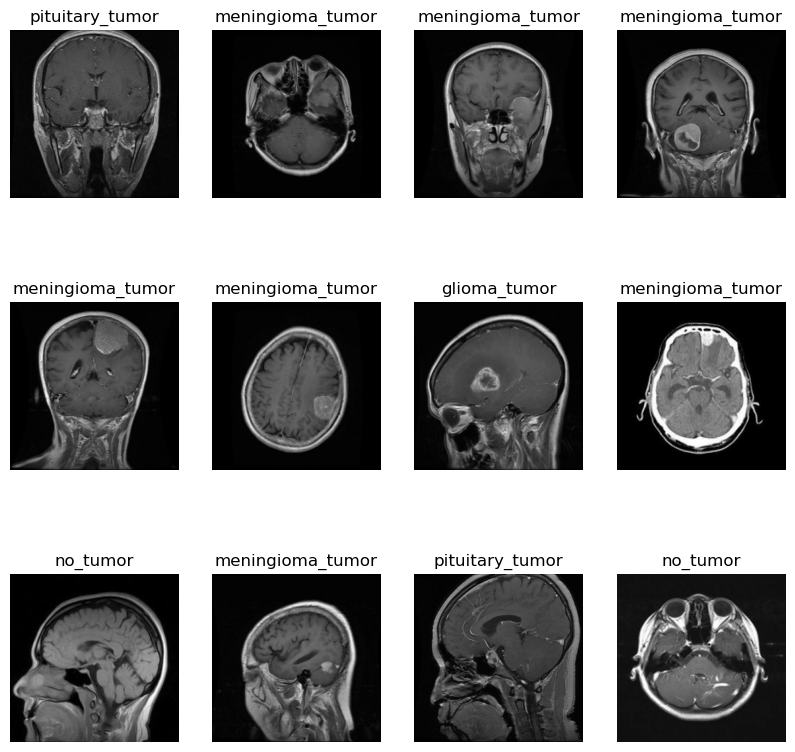

In [26]:
#look at 12 test images in the one batch
plt.figure(figsize=(10,10))
for im, label in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(im[i].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(class_names[label[i]])

In [30]:
#num of batch in val set
len(val_ds)

13

In [125]:
#function to get train, valid, and test datasets
def get_val_test(val_ds, test_prop):
    val_ds = val_ds.shuffle(10000)
    test_size = int(test_prop*len(val_ds))
    test_ds = val_ds.take(test_size)
    val_ds = val_ds.skip(test_size)
    return val_ds, test_ds

In [126]:
val_ds, test_ds = get_val_test(val_ds, 0.5)

In [127]:
len(test_ds)

6

In [128]:
#optimize datasets for training performance with caching & prefetch 
def optimize_ds():
    global train_ds, val_ds, test_ds
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

optimize_ds()

In [129]:
#preprocessing layers to resize and scale the images, not just in training but also when we're using the model later
resize_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [130]:
#data augmentation layer
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

# Build the model

In [184]:
n_classes=4
model = models.Sequential([
    resize_rescale,
    data_augmentation,
    layers.Conv2D(64,(3,3),activation='relu', input_shape=(IMAGE_SIZE,IMAGE_SIZE)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

In [192]:
model = models.Sequential([
    resize_rescale,
    data_augmentation,
    layers.Conv2D(64,(3,3),activation='relu', input_shape=(IMAGE_SIZE,IMAGE_SIZE)),
    layers.AveragePooling2D(2,2),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.AveragePooling2D(2,2),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.AveragePooling2D(2,2),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.AveragePooling2D(2,2),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.AveragePooling2D(2,2),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

In [193]:
model.build(input_shape=(BATCH_SIZE,IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

# Train the model

In [194]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [195]:
history = model.fit(train_ds, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, validation_data=val_ds)

Epoch 1/50
90/90 [==============================] - 632s 7s/step - loss: 1.1539 - accuracy: 0.4875 - val_loss: 1.7930 - val_accuracy: 0.2426
Epoch 2/50
90/90 [==============================] - 581s 6s/step - loss: 0.9914 - accuracy: 0.5784 - val_loss: 1.9803 - val_accuracy: 0.2772
Epoch 3/50
90/90 [==============================] - 626s 7s/step - loss: 0.8957 - accuracy: 0.6087 - val_loss: 2.2561 - val_accuracy: 0.2921
Epoch 4/50
90/90 [==============================] - 585s 6s/step - loss: 0.8026 - accuracy: 0.6659 - val_loss: 1.9803 - val_accuracy: 0.3812
Epoch 5/50
90/90 [==============================] - 867s 10s/step - loss: 0.7249 - accuracy: 0.7003 - val_loss: 2.5513 - val_accuracy: 0.4010
Epoch 6/50
90/90 [==============================] - 918s 10s/step - loss: 0.6764 - accuracy: 0.7188 - val_loss: 2.3336 - val_accuracy: 0.3515
Epoch 7/50
90/90 [==============================] - 542s 6s/step - loss: 0.6256 - accuracy: 0.7380 - val_loss: 3.9400 - val_accuracy: 0.4505
Epoch 8/50


In [196]:
scores = model.evaluate(test_ds)

6/6 [==============================] - 10s 2s/step - loss: 4.2522 - accuracy: 0.7588


# Using the model

In [201]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img.numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 43ms/step


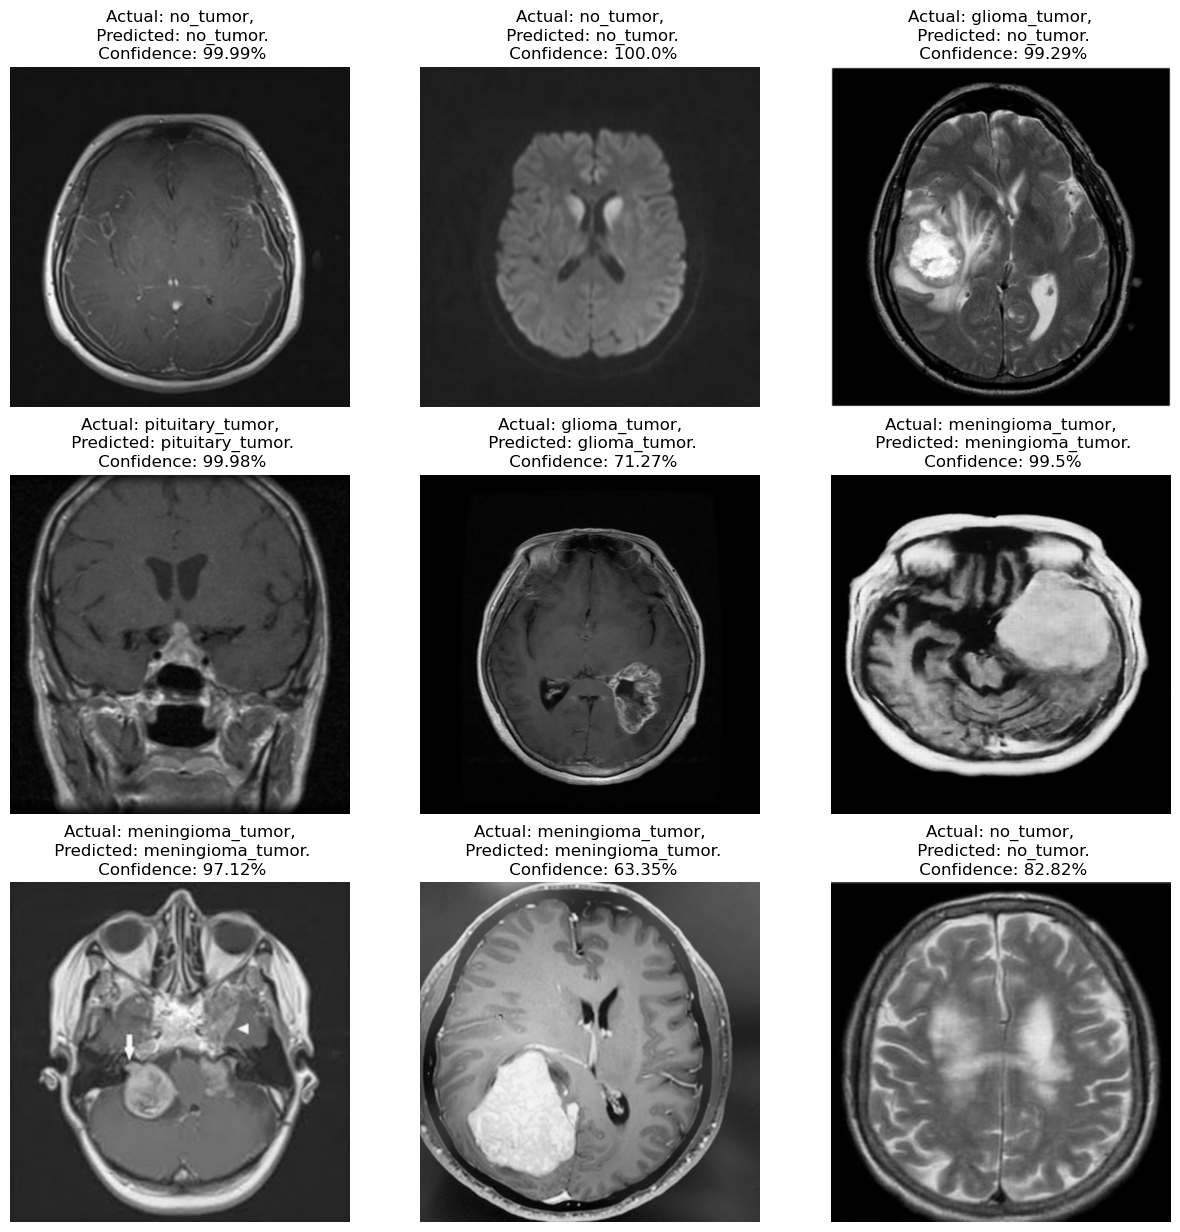

In [202]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

Save the model

In [198]:
import os

model_directory = "./models"
model_files = [int(file) for file in os.listdir(model_directory) if file.isdigit()]
model_version = max(model_files) + 1 if model_files else 1
model.save(f"{model_directory}/{model_version}")

INFO:tensorflow:Assets written to: ./models/2/assets


INFO:tensorflow:Assets written to: ./models/2/assets
